Soccer Team Recommendation system

In [2]:
import numpy as np 
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.patches import Rectangle, ConnectionPatch, Arc
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import os

players = pd.read_csv('/kaggle/input/fifa-22-complete-player-dataset/players_22.csv', low_memory=False) #using only FIFA 22 here
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [4]:
budget = 100000000

In [5]:
spread = budget/10
print(spread)

10000000.0


In [6]:
def plot_stats(player_list, labels,df):
    fig = go.Figure()
    
    try:
        for player in player_list:
            i = df[df.short_name.str.contains(player)][labels].index.item()
            stats = df.loc[i, labels].values

            fig.add_trace(go.Scatterpolar(
                  r=stats,
                  theta=labels,
                  fill='toself',
                  name=player
            ))
    except:
        print("Could not decode Player name")

    fig.update_layout(
            autosize=False,
            width=700,
            height=700,)

    fig.show()
    

In [7]:
for i in ["preferred_foot","work_rate"]:
    players[i] = players[i].astype("category")
    players[i] = players[i].cat.codes
    
players = players[players["value_eur"]<spread]
players.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
48,162835,https://sofifa.com/player/162835/samir-handano...,S. Handanovič,Samir Handanovič,GK,86,86,7500000.0,78000.0,36,1984-07-14,193,92,44.0,Inter,Italian Serie A,1.0,GK,1.0,NaN,2012-07-01,2022.0,44,Slovenia,NaN,NaN,NaN,1,3,1,3,8,Unique,Yes,12800000.0,NaN,"Solid Player, GK Long Throw, Team Player",NaN,NaN,NaN,NaN,NaN,NaN,12,10,10,42,12,18,20,14,40,21,45,50,47,79,36,49,78,41,69,19,25,22,12,41,23,69,25,10,13,81,81,65,92,87,47.0,30+3,30+3,30+3,29,31,31,31,29,33+3,33+3,33+3,31+3,34+3,34+3,34+3,31+3,30+3,33+3,33+3,33+3,30+3,29+3,29+3,29+3,29+3,29+3,84+2,https://cdn.sofifa.net/players/162/835/22_120.png,https://cdn.sofifa.net/teams/44/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/si.png
70,163587,https://sofifa.com/player/163587/kasper-schmei...,K. Schmeichel,Kasper Peter Schmeichel,GK,85,85,9000000.0,115000.0,34,1986-11-05,189,89,95.0,Leicester City,English Premier League,1.0,GK,1.0,NaN,2011-06-01,2023.0,13,Denmark,1331.0,GK,1.0,1,3,1,2,8,Stocky (185+),Yes,17100000.0,NaN,"Solid Player, Leadership, Team Player",NaN,NaN,NaN,NaN,NaN,NaN,18,12,16,44,15,12,13,15,46,40,45,51,61,82,47,60,60,34,64,14,35,20,13,59,26,67,14,14,13,84,78,80,83,90,47.0,33+2,33+2,33+2,33,35,35,35,33,38+2,38+2,38+2,35+2,39+2,39+2,39+2,35+2,31+2,36+2,36+2,36+2,31+2,30+2,29+2,29+2,29+2,30+2,83+2,https://cdn.sofifa.net/players/163/587/22_120.png,https://cdn.sofifa.net/teams/95/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1331/60.png,https://cdn.sofifa.net/flags/dk.png
71,164240,https://sofifa.com/player/164240/thiago-emilia...,Thiago Silva,Thiago Emiliano da Silva,CB,85,85,9500000.0,105000.0,36,1984-09-22,183,79,5.0,Chelsea,English Premier League,1.0,SUB,6.0,NaN,2020-08-28,2022.0,54,Brazil,NaN,NaN,NaN,1,3,2,4,6,Normal (170-185),Yes,17600000.0,#Tactician,"Leadership, Power Header",53.0,54.0,72.0,72.0,86.0,78.0,60,40,81,80,61,67,62,61,80,79,52,54,67,82,66,71,88,68,82,65,76,88,59,71,60,86,87,86,84,9,12,5,9,10,NaN,65+3,65+3,65+3,65,67,67,67,65,69+3,69+3,69+3,67+3,75+3,75+3,75+3,67+3,76+3,82+3,82+3,82+3,76+3,77+3,83+2,83+2,83+2,77+3,18+3,https://cdn.sofifa.net/players/164/240/22_120.png,https://cdn.sofifa.net/teams/5/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/br.png
140,135507,https://sofifa.com/player/135507/fernando-luiz...,Fernandinho,Fernando Luiz Rosa,"CDM, CB",83,83,7000000.0,100000.0,36,1985-05-04,179,67,10.0,Manchester City,English Premier League,1.0,SUB,25.0,NaN,2013-07-01,2022.0,54,Brazil,NaN,NaN,NaN,1,4,3,3,6,Lean (170-185),Yes,13000000.0,NaN,"Leadership, Team Player",59.0,72.0,75.0,78.0,84.0,75.0

In [8]:
goalkeeper = players[
    players.player_positions.str.contains('GK')
].reset_index(drop=True)
goalkeeper.head(3)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,162835,https://sofifa.com/player/162835/samir-handano...,S. Handanovič,Samir Handanovič,GK,86,86,7500000.0,78000.0,36,1984-07-14,193,92,44.0,Inter,Italian Serie A,1.0,GK,1.0,NaN,2012-07-01,2022.0,44,Slovenia,NaN,NaN,NaN,1,3,1,3,8,Unique,Yes,12800000.0,NaN,"Solid Player, GK Long Throw, Team Player",NaN,NaN,NaN,NaN,NaN,NaN,12,10,10,42,12,18,20,14,40,21,45,50,47,79,36,49,78,41,69,19,25,22,12,41,23,69,25,10,13,81,81,65,92,87,47.0,30+3,30+3,30+3,29,31,31,31,29,33+3,33+3,33+3,31+3,34+3,34+3,34+3,31+3,30+3,33+3,33+3,33+3,30+3,29+3,29+3,29+3,29+3,29+3,84+2,https://cdn.sofifa.net/players/162/835/22_120.png,https://cdn.sofifa.net/teams/44/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/si.png
1,163587,https://sofifa.com/player/163587/kasper-schmei...,K. Schmeichel,Kasper Peter Schmeichel,GK,85,85,9000000.0,115000.0,34,1986-11-05,189,89,95.0,Leicester City,English Premier League,1.0,GK,1.0,NaN,2011-06-01,2023.0,13,Denmark,1331.0,GK,1.0,1,3,1,2,8,Stocky (185+),Yes,17100000.0,NaN,"Solid Player, Leadership, Team Player",NaN,NaN,NaN,NaN,NaN,NaN,18,12,16,44,15,12,13,15,46,40,45,51,61,82,47,60,60,34,64,14,35,20,13,59,26,67,14,14,13,84,78,80,83,90,47.0,33+2,33+2,33+2,33,35,35,35,33,38+2,38+2,38+2,35+2,39+2,39+2,39+2,35+2,31+2,36+2,36+2,36+2,31+2,30+2,29+2,29+2,29+2,30+2,83+2,https://cdn.sofifa.net/players/163/587/22_120.png,https://cdn.sofifa.net/teams/95/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1331/60.png,https://cdn.sofifa.net/flags/dk.png
2,164835,https://sofifa.com/player/164835/lukasz-fabian...,Ł. Fabiański,Łukasz Fabiański,GK,82,82,3400000.0,43000.0,36,1985-04-18,190,83,19.0,West Ham United,English Premier League,1.0,GK,1.0,NaN,2018-06-20,2022.0,37,Poland,NaN,NaN,NaN,1,2,1,2,8,Normal (185+),Yes,6500000.0,NaN,"GK Long Throw, Comes For Crosses",NaN,NaN,NaN,NaN,NaN,NaN,14,13,11,20,17,14,18,12,32,22,50,47,53,75,44,53,69,25,65,20,43,16,15,52,22,63,14,12,13,82,82,71,83,82,49.0,29+2,29+2,29+2,28,30,30,30,28,30+2,30+2,30+2,29+2,29+2,29+2,29+2,29+2,25+2,27+2,27+2,27+2,25+2,25+2,27+2,27+2,27+2,25+2,81+1,https://cdn.sofifa.net/players/164/835/22_120.png,https://cdn.sofifa.net/teams/19/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/pl.png


In [9]:
defenders = players[
    players.player_positions.str.contains('\\b(?:LB)|(?:LWB)|(?:RB)|(?:RWB)|(?:CB)\\b', regex=True)
].reset_index(drop=True)

defenders.head(3)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,164240,https://sofifa.com/player/164240/thiago-emilia...,Thiago Silva,Thiago Emiliano da Silva,CB,85,85,9500000.0,105000.0,36,1984-09-22,183,79,5.0,Chelsea,English Premier League,1.0,SUB,6.0,NaN,2020-08-28,2022.0,54,Brazil,NaN,NaN,NaN,1,3,2,4,6,Normal (170-185),Yes,17600000.0,#Tactician,"Leadership, Power Header",53.0,54.0,72.0,72.0,86.0,78.0,60,40,81,80,61,67,62,61,80,79,52,54,67,82,66,71,88,68,82,65,76,88,59,71,60,86,87,86,84,9,12,5,9,10,NaN,65+3,65+3,65+3,65,67,67,67,65,69+3,69+3,69+3,67+3,75+3,75+3,75+3,67+3,76+3,82+3,82+3,82+3,76+3,77+3,83+2,83+2,83+2,77+3,18+3,https://cdn.sofifa.net/players/164/240/22_120.png,https://cdn.sofifa.net/teams/5/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/br.png
1,135507,https://sofifa.com/player/135507/fernando-luiz...,Fernandinho,Fernando Luiz Rosa,"CDM, CB",83,83,7000000.0,100000.0,36,1985-05-04,179,67,10.0,Manchester City,English Premier League,1.0,SUB,25.0,NaN,2013-07-01,2022.0,54,Brazil,NaN,NaN,NaN,1,4,3,3,6,Lean (170-185),Yes,13000000.0,NaN,"Leadership, Team Player",59.0,72.0,75.0,78.0,84.0,75.0,68,66,71,83,70,76,68,71,81,81,67,52,69,86,77,83,84,66,75,76,86,85,70,66,61,81,87,85,80,12,11,5,13,7,NaN,74+3,74+3,74+3,73,74,74,74,73,75+3,75+3,75+3,73+3,78+3,78+3,78+3,73+3,77+3,82+1,82+1,82+1,77+3,77+3,82+1,82+1,82+1,77+3,19+3,https://cdn.sofifa.net/players/135/507/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/br.png
2,120533,https://sofifa.com/player/120533/kepler-lavera...,Pepe,Kléper Laveran de Lima Ferreira,CB,82,82,5500000.0,14000.0,38,1983-02-26,188,80,236.0,FC Porto,Portuguese Liga ZON SAGRES,1.0,LCB,3.0,NaN,2019-01-08,2023.0,38,Portugal,1354.0,RCB,3.0,1,3,2,4,6,Lean (185+),Yes,11000000.0,NaN,"Dives Into Tackles (AI), Leadership",80.0,51.0,60.0,61.0,82.0,87.0,46,46,81,73,23,58,44,47,75,60,79,81,62,81,48,63,89,82,86,56,94,78,40,48,57,80,86,82,81,8,15,5,9,10,NaN,62+3,62+3,62+3,60,60,60,60,60,61+3,61+3,61+3,62+3,66+3,66+3,66+3,62+3,73+3,77+3,77+3,77+3,73+3,76+3,82,82,82,76+3,18+3,https://cdn.sofifa.net/players/120/533/22_120.png,https://cdn.sofifa.net/teams/236/60.png,https://cdn.sofifa.net/flags/pt.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [10]:
midfield = players[
    players.player_positions.str.contains('\\b(?:CM)|(?:CDM)|(?:CAM)\\b', regex=True)
].reset_index(drop=True)

midfield.head(3)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,135507,https://sofifa.com/player/135507/fernando-luiz...,Fernandinho,Fernando Luiz Rosa,"CDM, CB",83,83,7000000.0,100000.0,36,1985-05-04,179,67,10.0,Manchester City,English Premier League,1.0,SUB,25.0,NaN,2013-07-01,2022.0,54,Brazil,NaN,NaN,NaN,1,4,3,3,6,Lean (170-185),Yes,13000000.0,NaN,"Leadership, Team Player",59.0,72.0,75.0,78.0,84.0,75.0,68,66,71,83,70,76,68,71,81,81,67,52,69,86,77,83,84,66,75,76,86,85,70,66,61,81,87,85,80,12,11,5,13,7,NaN,74+3,74+3,74+3,73,74,74,74,73,75+3,75+3,75+3,73+3,78+3,78+3,78+3,73+3,77+3,82+1,82+1,82+1,77+3,77+3,82+1,82+1,82+1,77+3,19+3,https://cdn.sofifa.net/players/135/507/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/br.png
1,176266,https://sofifa.com/player/176266/lucas-pezzini...,Lucas Leiva,Lucas Pezzini Leiva,CDM,81,81,9000000.0,64000.0,34,1987-01-09,179,78,46.0,Lazio,Italian Serie A,1.0,CDM,6.0,NaN,2017-07-18,2022.0,54,Brazil,NaN,NaN,NaN,1,3,3,3,3,Normal (170-185),Yes,15300000.0,#Tactician,Dives Into Tackles (AI),56.0,65.0,73.0,76.0,82.0,69.0,63,62,72,78,59,74,74,47,77,77,57,55,71,80,80,75,81,66,65,63,82,86,66,77,61,86,82,82,79,10,8,8,5,6,NaN,69+3,69+3,69+3,70,71,71,71,70,73+3,73+3,73+3,70+3,76+3,76+3,76+3,70+3,74+3,79+2,79+2,79+2,74+3,75+3,78+3,78+3,78+3,75+3,15+3,https://cdn.sofifa.net/players/176/266/22_120.png,https://cdn.sofifa.net/teams/46/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/br.png
2,162347,https://sofifa.com/player/162347/joao-filipe-m...,João Moutinho,João Filipe Iria Santos Moutinho,CM,80,80,9500000.0,88000.0,34,1986-09-08,170,61,110.0,Wolverhampton Wanderers,English Premier League,1.0,LCM,28.0,NaN,2018-07-24,2022.0,38,Portugal,1354.0,SUB,8.0,1,4,3,3,6,Normal (170-),Yes,18100000.0,NaN,"Leadership, Long Passer (AI), Playmaker (AI), ...",50.0,72.0,84.0,80.0,70.0,66.0,85,68,68,86,76,76,84,82,83,85,55,45,75,75,85,77,69,75,57,77,74,70,68,83,70,89,71,70,68,13,15,15,13,13,NaN,71+3,71+3,71+3,74,74,74,74,74,77+3,77+3,77+3,75+3,79+1,79+1,79+1,75+3,73+3,76+3,76+3,76+3,73+3,72+3,70+3,70+3,70+3,72+3,20+3,https://cdn.sofifa.net/players/162/347/22_120.png,https://cdn.sofifa.net/teams/110/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [11]:
forwards = players[
    players.player_positions.str.contains('\\b(?:LW)|(?:LM)|(?:RW)|(?:RM)|(?:ST)|(?:CF)\\b', regex=True)
].reset_index(drop=True)

forwards.head(3)

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,45186,https://sofifa.com/player/45186/joaquin-sanche...,Joaquín,Joaquín Sánchez Rodríguez,"RM, LM",81,81,8500000.0,23000.0,39,1981-07-21,179,75,449.0,Real Betis Balompié,Spain Primera Division,1.0,RM,17.0,NaN,2015-09-01,2022.0,45,Spain,NaN,NaN,NaN,1,3,4,2,2,Normal (170-185),Yes,17900000.0,NaN,"Leadership, Flair, Technical Dribbler (AI)",68.0,80.0,84.0,81.0,44.0,55.0,84,83,65,84,68,84,86,77,83,83,65,70,69,84,69,80,31,42,64,78,55,35,84,85,75,81,41,47,39,9,14,6,10,11,NaN,78+2,78+2,78+2,81,81,81,81,81,82-1,82-1,82-1,80+1,77+2,77+2,77+2,80+1,61+2,62+2,62+2,62+2,61+2,58+2,53+2,53+2,53+2,58+2,19+2,https://cdn.sofifa.net/players/045/186/22_120.png,https://cdn.sofifa.net/teams/449/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/es.png
1,156616,https://sofifa.com/player/156616/franck-ribery...,F. Ribéry,Franck Bilal Ribéry,"CF, LW",79,79,6000000.0,41000.0,38,1983-04-07,170,72,110373.0,US Salernitana 1919,Italian Serie A,1.0,RS,7.0,NaN,2021-09-06,2022.0,18,France,NaN,NaN,NaN,1,5,5,4,1,Normal (170-),Yes,10800000.0,#Dribbler,"Injury Prone, Flair, Outside Foot Shot, Techni...",69.0,73.0,81.0,85.0,30.0,53.0,74,71,41,85,79,87,83,81,82,89,69,69,74,69,87,79,33,54,55,68,51,33,79,81,78,81,31,25,26,15,6,9,7,10,NaN,72+3,72+3,72+3,79,78,78,78,79,80-1,80-1,80-1,78+1,75+3,75+3,75+3,78+1,57+3,57+3,57+3,57+3,57+3,51+3,42+3,42+3,42+3,51+3,16+3,https://cdn.sofifa.net/players/156/616/22_120.png,https://cdn.sofifa.net/teams/110373/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/fr.png
2,159145,https://sofifa.com/player/159145/bafetimbi-gom...,B. Gomis,Bafétimbi Fredius Gomis,ST,79,79,7500000.0,38000.0,35,1985-08-06,186,86,605.0,Al Hilal,Saudi Abdul L. Jameel League,1.0,LS,18.0,NaN,2018-08-23,2022.0,18,France,NaN,NaN,NaN,1,4,3,3,1,Normal (170-185),Yes,12800000.0,NaN,"Solid Player, Leadership, Power Header",60.0,81.0,68.0,72.0,36.0,74.0,64,82,84,75,83,72,61,62,54,80,55,64,52,80,47,84,76,75,83,72,52,38,82,73,83,81,22,32,35,14,11,9,9,13,NaN,79,79,79,73,76,76,76,73,74+3,74+3,74+3,72+3,69+3,69+3,69+3,72+3,57+3,56+3,56+3,56+3,57+3,54+3,52+3,52+3,52+3,54+3,19+3,https://cdn.sofifa.net/players/159/145/22_120.png,https://cdn.sofifa.net/teams/605/60.png,https://cdn.sofifa.net/flags/sa.png,NaN,https://cdn.sofifa.net/flags/fr.png


What Makes a Good Fowards Player - Using MAchine learning to Analyze

In [12]:
forward_train = forwards.drop(forwards.select_dtypes("object").columns, axis=1) 
X = forward_train.drop(["overall","value_eur","age","wage_eur","release_clause_eur"], axis=1)
y = forward_train.overall
from sklearn.model_selection import KFold
predictions = []
score = []
fold=KFold(n_splits=4,shuffle=True, random_state=2021)
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    model3=CatBoostRegressor(learning_rate=0.1, n_estimators=10000, use_best_model= True, eval_metric='RMSE')
    model3.fit(X_train, Y_train, early_stopping_rounds=200, 
            eval_set=[(X_test, Y_test)],        verbose=500)
    score.append(mean_squared_error(Y_test, model3.predict(X_test), squared=False))
    print("ive done for this fold")
print("The Mean Squared Error is ",np.mean(score))

0:	learn: 5.3273645	test: 5.4614740	best: 5.4614740 (0)	total: 59.8ms	remaining: 9m 58s
500:	learn: 0.4575237	test: 0.7796753	best: 0.7796165 (495)	total: 1.97s	remaining: 37.4s
1000:	learn: 0.2799537	test: 0.7651120	best: 0.7650069 (993)	total: 3.86s	remaining: 34.7s
1500:	learn: 0.1810368	test: 0.7625084	best: 0.7623971 (1418)	total: 5.78s	remaining: 32.7s
2000:	learn: 0.1212272	test: 0.7604947	best: 0.7604770 (1963)	total: 7.76s	remaining: 31s
2500:	learn: 0.0808960	test: 0.7595649	best: 0.7594561 (2474)	total: 9.81s	remaining: 29.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7594560925
bestIteration = 2474

Shrink model to first 2475 iterations.
ive done for this fold
0:	learn: 5.3818766	test: 5.3715576	best: 5.3715576 (0)	total: 7.09ms	remaining: 1m 10s
500:	learn: 0.4571427	test: 0.7572640	best: 0.7572640 (500)	total: 2.22s	remaining: 42.1s
1000:	learn: 0.2776760	test: 0.7410256	best: 0.7409999 (999)	total: 4.15s	remaining: 37.3s
1500:	learn: 0.1801183	t

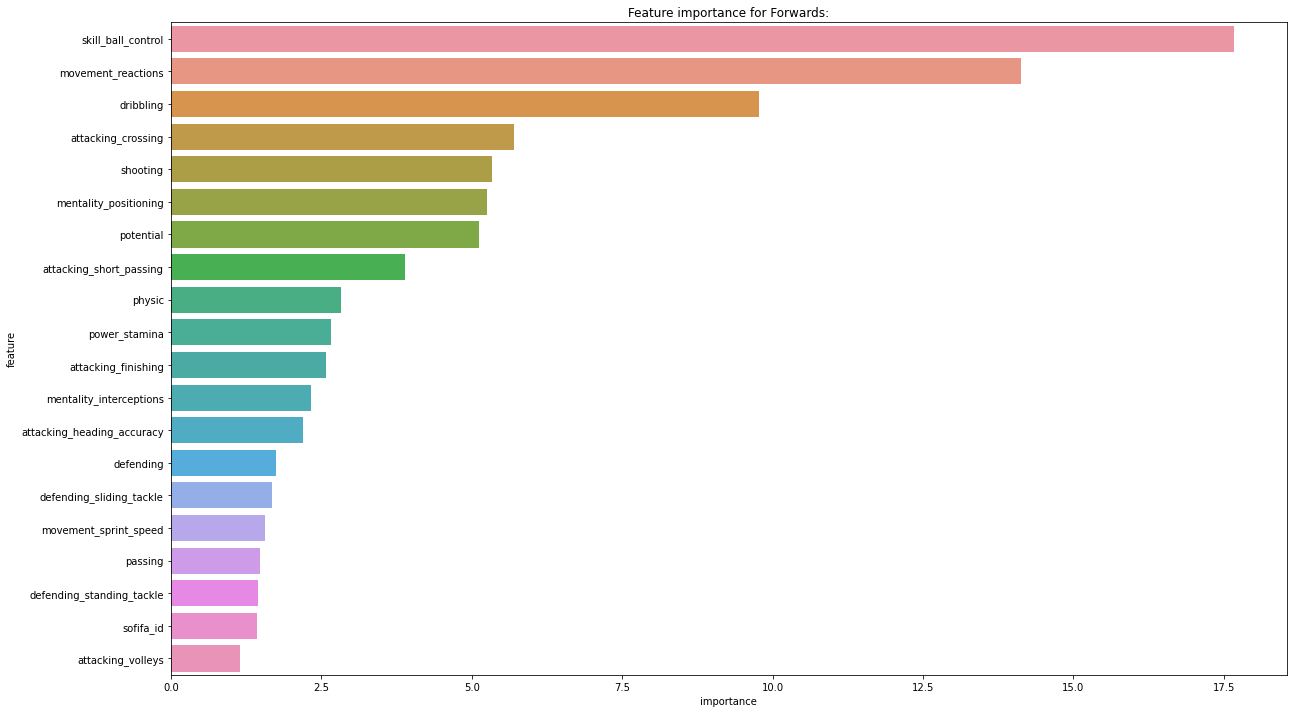

In [14]:
feature_importance_df = pd.DataFrame(model3.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns
 
plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(20))
plt.title('Feature importance for Forwards:');

Arrage the Forward strikers based in the top 10 most important features

In [15]:
forward_labels = feature_importance_df.sort_values(by = ['importance'], ascending = False).feature[:10].tolist()
forwards = forwards.sort_values(by= forward_labels,
               ascending = [False for i in forward_labels]).reset_index(drop=True)
forwards.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,156616,https://sofifa.com/player/156616/franck-ribery...,F. Ribéry,Franck Bilal Ribéry,"CF, LW",79,79,6000000.0,41000.0,38,1983-04-07,170,72,110373.0,US Salernitana 1919,Italian Serie A,1.0,RS,7.0,NaN,2021-09-06,2022.0,18,France,NaN,NaN,NaN,1,5,5,4,1,Normal (170-),Yes,10800000.0,#Dribbler,"Injury Prone, Flair, Outside Foot Shot, Techni...",69.0,73.0,81.0,85.0,30.0,53.0,74,71,41,85,79,87,83,81,82,89,69,69,74,69,87,79,33,54,55,68,51,33,79,81,78,81,31,25,26,15,6,9,7,10,NaN,72+3,72+3,72+3,79,78,78,78,79,80-1,80-1,80-1,78+1,75+3,75+3,75+3,78+1,57+3,57+3,57+3,57+3,57+3,51+3,42+3,42+3,42+3,51+3,16+3,https://cdn.sofifa.net/players/156/616/22_120.png,https://cdn.sofifa.net/teams/110373/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/fr.png
1,189505,https://sofifa.com/player/189505/pedro-rodrigu...,Pedro,Pedro Eliezer Rodríguez Ledesma,"CF, RW",78,78,9000000.0,61000.0,33,1987-07-28,169,65,46.0,Lazio,Italian Serie A,1.0,RW,9.0,NaN,2021-08-19,2024.0,45,Spain,NaN,NaN,NaN,1,5,4,3,8,Lean (170-),Yes,15300000.0,#Acrobat,"Finesse Shot, Long Shot Taker (AI), Outside Fo...",74.0,73.0,77.0,84.0,40.0,52.0,74,73,39,80,70,81,81,57,71,88,84,66,90,75,90,75,66,68,40,75,58,49,75,81,66,81,44,32,31,5,11,12,15,9,NaN,71+3,71+3,71+3,79-1,78,78,78,79-1,80-2,80-2,80-2,78,74+3,74+3,74+3,78,62+3,60+3,60+3,60+3,62+3,58+3,48+3,48+3,48+3,58+3,17+3,https://cdn.sofifa.net/players/189/505/22_120.png,https://cdn.sofifa.net/teams/46/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/es.png
2,215455,https://sofifa.com/player/215455/bruno-petkovi...,B. Petković,Bruno Petković,"ST, CAM",76,77,9000000.0,1000.0,26,1994-09-16,193,88,211.0,Dinamo Zagreb,Croatian Prva HNL,1.0,ST,21.0,NaN,2018-08-06,2024.0,10,Croatia,NaN,NaN,NaN,1,4,4,1,6,Normal (185+),No,20500000.0,#Strength,"Flair, Playmaker (AI), Technical Dribbler (AI)",75.0,72.0,75.0,80.0,39.0,77.0,66,72,78,79,78,83,69,76,70,85,74,76,77,68,49,82,75,73,92,61,44,23,64,84,86,79,39,41,29,11,15,9,14,10,NaN,76+1,76+1,76+1,75,76,76,76,75,77,77,77,76+1,72+2,72+2,72+2,76+1,58+2,58+2,58+2,58+2,58+2,55+2,53+2,53+2,53+2,55+2,18+2,https://cdn.sofifa.net/players/215/455/22_120.png,https://cdn.sofifa.net/teams/211/60.png,https://cdn.sofifa.net/flags/hr.png,NaN,https://cdn.sofifa.net/flags/hr.png
3,178088,https://sofifa.com/player/178088/juan-manuel-m...,Juan Mata,Juan Manuel Mata García,"CAM, RM",78,78,9000000.0,100000.0,33,1988-04-28,170,63,11.0,Manchester United,English Premier League,1.0,SUB,8.0,NaN,2014-01-25,2022.0,45,Spain,NaN,NaN,NaN,0,3,4,3,8,Lean (170-),Yes,16700000.0,NaN,"Solid Player, Finesse Shot, Playmaker (

In [16]:
plot_stats(forwards.short_name[:3].to_list(),forward_labels, forwards)

Could not decode Player name


In [17]:
midfield_train = midfield.drop(midfield.select_dtypes("object").columns, axis=1) 
X = midfield_train.drop(["overall","value_eur","age","wage_eur","release_clause_eur"], axis=1)
y = midfield_train.overall
from sklearn.model_selection import KFold
predictions = []
score = []
fold=KFold(n_splits=4,shuffle=True, random_state=2021)
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    model3=CatBoostRegressor(learning_rate=0.1, n_estimators=10000, use_best_model= True, eval_metric='RMSE')
    model3.fit(X_train, Y_train, early_stopping_rounds=200, 
            eval_set=[(X_test, Y_test)],        verbose=500)
    score.append(mean_squared_error(Y_test, model3.predict(X_test), squared=False))
    print("ive done for this fold")
print("The Mean Squared Error is ", np.mean(score))

0:	learn: 5.5637629	test: 5.6571775	best: 5.6571775 (0)	total: 4.26ms	remaining: 42.6s
500:	learn: 0.4876382	test: 0.9234280	best: 0.9234280 (500)	total: 1.76s	remaining: 33.5s
1000:	learn: 0.2791711	test: 0.9098801	best: 0.9098202 (994)	total: 3.88s	remaining: 34.9s
1500:	learn: 0.1640383	test: 0.9066264	best: 0.9066264 (1500)	total: 5.61s	remaining: 31.8s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9064180597
bestIteration = 1503

Shrink model to first 1504 iterations.
ive done for this fold
0:	learn: 5.5607069	test: 5.6608625	best: 5.6608625 (0)	total: 4.08ms	remaining: 40.8s
500:	learn: 0.4941467	test: 0.8979681	best: 0.8979681 (500)	total: 2s	remaining: 37.9s
1000:	learn: 0.2777342	test: 0.8858492	best: 0.8855810 (920)	total: 3.72s	remaining: 33.5s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8849204128
bestIteration = 1139

Shrink model to first 1140 iterations.
ive done for this fold
0:	learn: 5.6050433	test: 5.5041142	best: 5.504

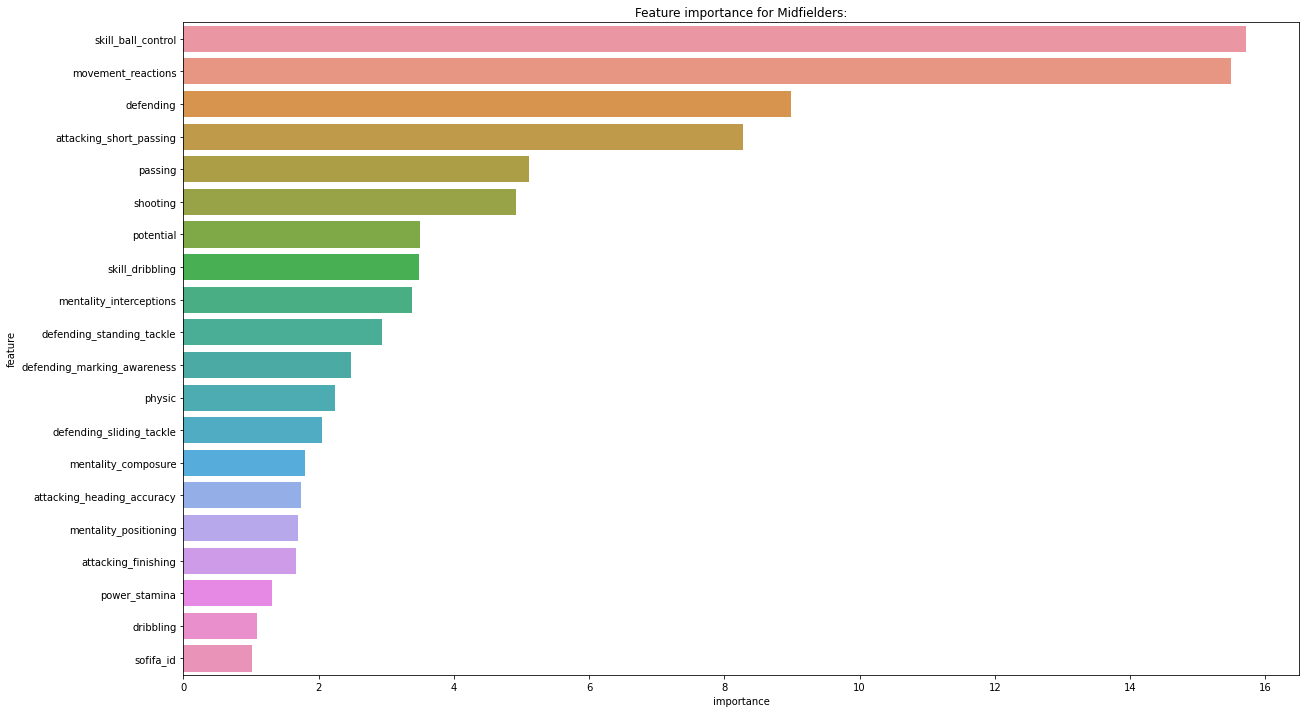

In [18]:
feature_importance_df = pd.DataFrame(model3.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns
 
plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(20))
plt.title('Feature importance for Midfielders:');

In [19]:
midfield_labels = feature_importance_df.sort_values(by = ['importance'], ascending = False).feature[:10].tolist()
midfield = midfield.sort_values(by=midfield_labels,
               ascending = [False for i in midfield_labels]).reset_index(drop=True)
midfield.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,41,https://sofifa.com/player/41/andres-iniesta-lu...,Iniesta,Andrés Iniesta Luján,"CM, CAM",79,79,5500000.0,10000.0,37,1984-05-11,171,68,101146.0,Vissel Kobe,Japanese J. League Division 1,1.0,CAM,8.0,NaN,2018-07-16,2024.0,45,Spain,NaN,NaN,NaN,1,4,4,4,7,Normal (170-),Yes,7200000.0,#Playmaker,"Injury Prone, Finesse Shot, Playmaker (AI), Ou...",51.0,69.0,84.0,84.0,59.0,57.0,75,68,54,89,79,84,80,70,83,89,59,44,72,71,76,67,40,51,62,70,58,59,78,90,71,89,68,53,50,6,13,6,13,7,NaN,71+3,71+3,71+3,77,77,77,77,77,81-2,81-2,81-2,77+2,79,79,79,77+2,66+3,70+3,70+3,70+3,66+3,63+3,61+3,61+3,61+3,63+3,16+3,https://cdn.sofifa.net/players/000/041/22_120.png,https://cdn.sofifa.net/teams/101146/60.png,https://cdn.sofifa.net/flags/jp.png,NaN,https://cdn.sofifa.net/flags/es.png
1,179605,https://sofifa.com/player/179605/adel-taarabt/...,A. Taarabt,Adel Taarabt,"CM, CAM",77,77,8500000.0,15000.0,32,1989-05-24,180,76,234.0,SL Benfica,Portuguese Liga ZON SAGRES,1.0,SUB,49.0,NaN,2015-07-01,2023.0,129,Morocco,NaN,NaN,NaN,1,4,4,2,8,Normal (170-185),Yes,17000000.0,#Dribbler,"Flair, Playmaker (AI), Outside Foot Shot, Tech...",68.0,69.0,77.0,84.0,65.0,74.0,75,65,36,78,73,86,81,71,74,85,69,67,80,80,78,76,37,78,71,68,87,68,74,79,70,83,68,69,64,4,6,4,4,6,NaN,71+2,71+2,71+2,77,76,76,76,77,78-1,78-1,78-1,77,77,77,77,77,74+2,75+2,75+2,75+2,74+2,71+2,67+2,67+2,67+2,71+2,13+2,https://cdn.sofifa.net/players/179/605/22_120.png,https://cdn.sofifa.net/teams/234/60.png,https://cdn.sofifa.net/flags/pt.png,NaN,https://cdn.sofifa.net/flags/ma.png
2,162347,https://sofifa.com/player/162347/joao-filipe-m...,João Moutinho,João Filipe Iria Santos Moutinho,CM,80,80,9500000.0,88000.0,34,1986-09-08,170,61,110.0,Wolverhampton Wanderers,English Premier League,1.0,LCM,28.0,NaN,2018-07-24,2022.0,38,Portugal,1354.0,SUB,8.0,1,4,3,3,6,Normal (170-),Yes,18100000.0,NaN,"Leadership, Long Passer (AI), Playmaker (AI), ...",50.0,72.0,84.0,80.0,70.0,66.0,85,68,68,86,76,76,84,82,83,85,55,45,75,75,85,77,69,75,57,77,74,70,68,83,70,89,71,70,68,13,15,15,13,13,NaN,71+3,71+3,71+3,74,74,74,74,74,77+3,77+3,77+3,75+3,79+1,79+1,79+1,75+3,73+3,76+3,76+3,76+3,73+3,72+3,70+3,70+3,70+3,72+3,20+3,https://cdn.sofifa.net/players/162/347/22_120.png,https://cdn.sofifa.net/teams/110/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png
3,215455,https://sofifa.com/player/215455/bruno-petkovi...,B. Petković,Bruno Petković,"ST, CAM",76,77,9000000.0,1000.0,26,1994-09-16,193,88,211.0,Dinamo Zagreb,Croatian Prva HNL,1.0,ST,21.0,NaN,2018-08-06,2024.0,10,Croatia,NaN,NaN,NaN,1,4,4,1,6,Normal 

In [20]:
plot_stats(midfield.short_name[:3].to_list(),midfield_labels,midfield)

In [21]:
defender_train = defenders.drop(defenders.select_dtypes("object").columns, axis=1) 
X = defender_train.drop(["overall","value_eur","age","wage_eur","release_clause_eur"], axis=1)
y = defender_train.overall
from sklearn.model_selection import KFold
predictions = []
score = []
fold=KFold(n_splits=4,shuffle=True, random_state=2021)
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    model3=CatBoostRegressor(learning_rate=0.1, n_estimators=10000, use_best_model= True, eval_metric='RMSE')
    model3.fit(X_train, Y_train, early_stopping_rounds=200, 
            eval_set=[(X_test, Y_test)],        verbose=500)
    score.append(mean_squared_error(Y_test, model3.predict(X_test), squared=False))
    print("ive done for this fold")
print("The Mean Squared Error is ", np.mean(score))

0:	learn: 5.4070784	test: 5.2883164	best: 5.2883164 (0)	total: 5.21ms	remaining: 52.1s
500:	learn: 0.3646464	test: 0.7032307	best: 0.7030766 (498)	total: 1.83s	remaining: 34.7s
1000:	learn: 0.2069918	test: 0.6931839	best: 0.6931839 (1000)	total: 3.65s	remaining: 32.8s
1500:	learn: 0.1262745	test: 0.6919843	best: 0.6917131 (1405)	total: 5.49s	remaining: 31.1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6914751976
bestIteration = 1672

Shrink model to first 1673 iterations.
ive done for this fold
0:	learn: 5.3471861	test: 5.4927403	best: 5.4927403 (0)	total: 4.69ms	remaining: 46.9s
500:	learn: 0.3693766	test: 0.7107576	best: 0.7107067 (499)	total: 1.82s	remaining: 34.5s
1000:	learn: 0.2167141	test: 0.6990909	best: 0.6987089 (926)	total: 3.69s	remaining: 33.2s
1500:	learn: 0.1314333	test: 0.6972943	best: 0.6971413 (1367)	total: 5.54s	remaining: 31.4s
2000:	learn: 0.0845951	test: 0.6970886	best: 0.6967209 (1853)	total: 7.38s	remaining: 29.5s
Stopped by overfitting 

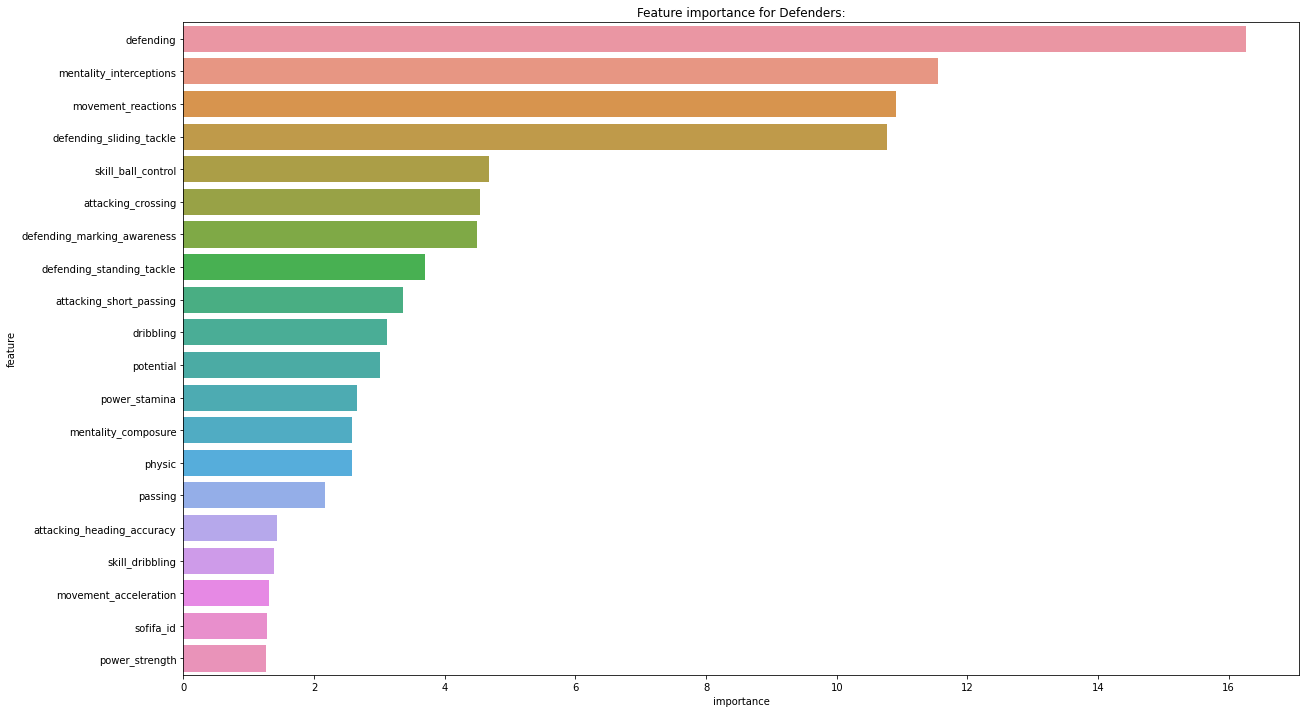

In [23]:
feature_importance_df = pd.DataFrame(model3.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns
 
plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(20))
plt.title('Feature importance for Defenders:');

In [24]:
defenders_labels = feature_importance_df.sort_values(by = ['importance'], ascending = False).feature[:10].tolist()
defenders = defenders.sort_values(by=defenders_labels,
               ascending = [False for i in defenders_labels])
defenders.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,164240,https://sofifa.com/player/164240/thiago-emilia...,Thiago Silva,Thiago Emiliano da Silva,CB,85,85,9500000.0,105000.0,36,1984-09-22,183,79,5.0,Chelsea,English Premier League,1.0,SUB,6.0,NaN,2020-08-28,2022.0,54,Brazil,NaN,NaN,NaN,1,3,2,4,6,Normal (170-185),Yes,17600000.0,#Tactician,"Leadership, Power Header",53.0,54.0,72.0,72.0,86.0,78.0,60,40,81,80,61,67,62,61,80,79,52,54,67,82,66,71,88,68,82,65,76,88,59,71,60,86,87,86,84,9,12,5,9,10,NaN,65+3,65+3,65+3,65,67,67,67,65,69+3,69+3,69+3,67+3,75+3,75+3,75+3,67+3,76+3,82+3,82+3,82+3,76+3,77+3,83+2,83+2,83+2,77+3,18+3,https://cdn.sofifa.net/players/164/240/22_120.png,https://cdn.sofifa.net/teams/5/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/br.png
3,157481,https://sofifa.com/player/157481/raul-albiol-t...,Raúl Albiol,Raúl Albiol Tortajada,CB,82,82,8000000.0,30000.0,35,1985-09-04,190,82,483.0,Villarreal CF,Spain Primera Division,1.0,RCB,3.0,NaN,2019-07-04,2022.0,45,Spain,NaN,NaN,NaN,1,3,2,3,3,Lean (185+),Yes,16800000.0,"#Tackling, #Tactician","Dives Into Tackles (AI), Leadership, Long Pass...",40.0,41.0,62.0,63.0,86.0,73.0,38,27,77,74,31,59,53,45,72,71,48,34,49,82,53,65,76,51,80,53,81,86,30,64,37,75,89,87,85,8,6,5,9,8,NaN,54+3,54+3,54+3,53,56,56,56,53,59+3,59+3,59+3,56+3,67+3,67+3,67+3,56+3,68+3,78+3,78+3,78+3,68+3,71+3,82,82,82,71+3,16+3,https://cdn.sofifa.net/players/157/481/22_120.png,https://cdn.sofifa.net/teams/483/60.png,https://cdn.sofifa.net/flags/es.png,NaN,https://cdn.sofifa.net/flags/es.png
1,135507,https://sofifa.com/player/135507/fernando-luiz...,Fernandinho,Fernando Luiz Rosa,"CDM, CB",83,83,7000000.0,100000.0,36,1985-05-04,179,67,10.0,Manchester City,English Premier League,1.0,SUB,25.0,NaN,2013-07-01,2022.0,54,Brazil,NaN,NaN,NaN,1,4,3,3,6,Lean (170-185),Yes,13000000.0,NaN,"Leadership, Team Player",59.0,72.0,75.0,78.0,84.0,75.0,68,66,71,83,70,76,68,71,81,81,67,52,69,86,77,83,84,66,75,76,86,85,70,66,61,81,87,85,80,12,11,5,13,7,NaN,74+3,74+3,74+3,73,74,74,74,73,75+3,75+3,75+3,73+3,78+3,78+3,78+3,73+3,77+3,82+1,82+1,82+1,77+3,77+3,82+1,82+1,82+1,77+3,19+3,https://cdn.sofifa.net/players/135/507/22_120.png,https://cdn.sofifa.net/teams/10/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/br.png
4,171791,https://sofifa.com/player/171791/jose-miguel-d...,José Fonte,José Miguel da Rocha Fonte,CB,81,81,4600000.0,30000.0,37,1983-12-22,191,84,65.0,LOSC Lille,French Ligue 1,1.0,RCB,6.0,NaN,2018-07-15,2022.0,38,Portugal,NaN,NaN,NaN,1,3,2,3,6,Lean (185+),Yes,8700000.0,NaN,"Solid Player, Dives Into Tackles (AI), Leaders...",32.0,46.0,62.0,63.0,83.0,7

In [25]:
plot_stats(defenders.short_name[:3].to_list(),defenders_labels,defenders)

In [26]:
goalkeeper_train = goalkeeper.drop(goalkeeper.select_dtypes("object").columns, axis=1) 
X = goalkeeper_train.drop(["overall","value_eur","age","wage_eur","release_clause_eur"], axis=1)
y = goalkeeper_train.overall
from sklearn.model_selection import KFold
predictions = []
score = []
fold=KFold(n_splits=4,shuffle=True, random_state=2021)
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    model3=CatBoostRegressor(learning_rate=0.1, n_estimators=10000, use_best_model= True, eval_metric='RMSE')
    model3.fit(X_train, Y_train, early_stopping_rounds=200, 
            eval_set=[(X_test, Y_test)],        verbose=500)
    score.append(mean_squared_error(Y_test, model3.predict(X_test), squared=False))
    print("ive done for this fold")
print("The Mean Squared Error is ", np.mean(score))

0:	learn: 6.3085766	test: 6.2173122	best: 6.2173122 (0)	total: 2.84ms	remaining: 28.4s
500:	learn: 0.1213056	test: 0.4555052	best: 0.4554347 (499)	total: 1.14s	remaining: 21.6s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.4539893894
bestIteration = 565

Shrink model to first 566 iterations.
ive done for this fold
0:	learn: 6.2313833	test: 6.4831383	best: 6.4831383 (0)	total: 3.52ms	remaining: 35.2s
500:	learn: 0.1111236	test: 0.5690638	best: 0.5689017 (498)	total: 1.29s	remaining: 24.4s
1000:	learn: 0.0309378	test: 0.5675188	best: 0.5672207 (953)	total: 2.59s	remaining: 23.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.5672206573
bestIteration = 953

Shrink model to first 954 iterations.
ive done for this fold
0:	learn: 6.3572757	test: 6.0904448	best: 6.0904448 (0)	total: 2.5ms	remaining: 25s
500:	learn: 0.1252500	test: 0.4985856	best: 0.4983533 (496)	total: 1.2s	remaining: 22.7s
Stopped by overfitting detector  (200 iterations wait)

be

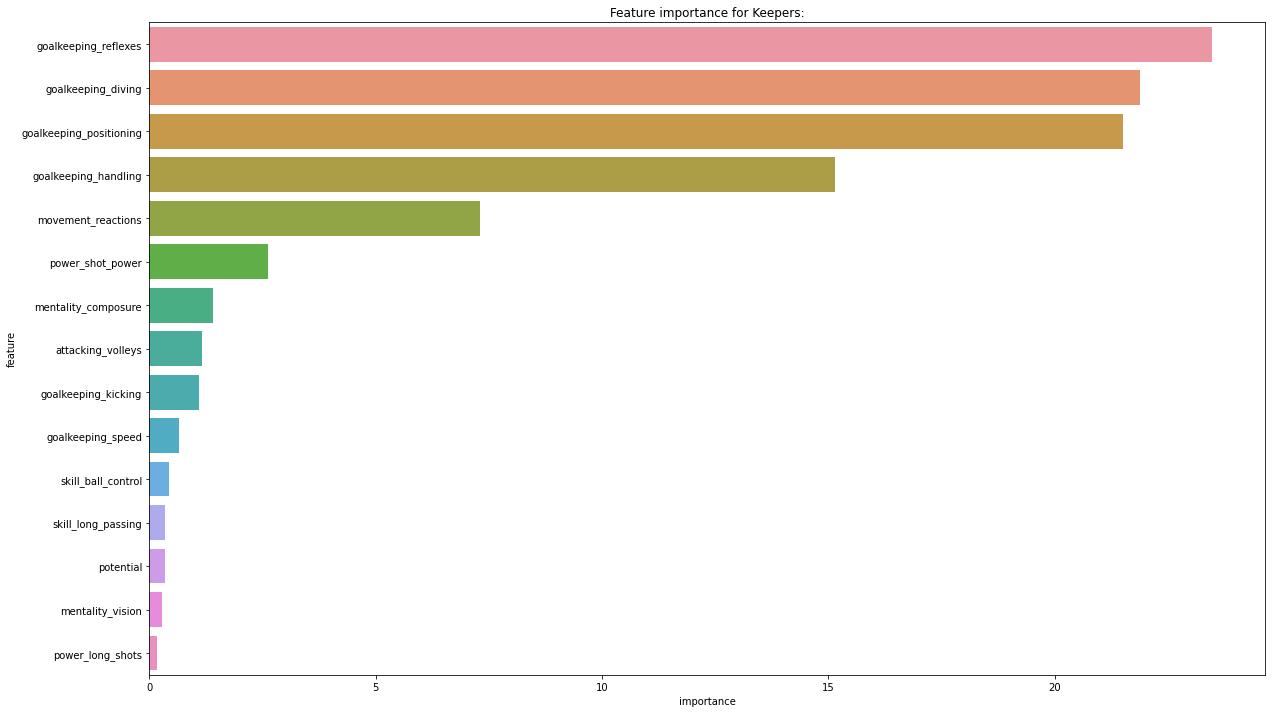

In [30]:
feature_importance_df = pd.DataFrame(model3.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns
 
plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(15))
plt.title('Feature importance for Keepers:');

In [31]:
goalkeeper_labels = feature_importance_df.sort_values(by = ['importance'], ascending = False).feature[:10].tolist()
goalkeeper = goalkeeper.sort_values(by= goalkeeper_labels,
               ascending = [False for i in goalkeeper_labels])
goalkeeper.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
1,163587,https://sofifa.com/player/163587/kasper-schmei...,K. Schmeichel,Kasper Peter Schmeichel,GK,85,85,9000000.0,115000.0,34,1986-11-05,189,89,95.0,Leicester City,English Premier League,1.0,GK,1.0,NaN,2011-06-01,2023.0,13,Denmark,1331.0,GK,1.0,1,3,1,2,8,Stocky (185+),Yes,17100000.0,NaN,"Solid Player, Leadership, Team Player",NaN,NaN,NaN,NaN,NaN,NaN,18,12,16,44,15,12,13,15,46,40,45,51,61,82,47,60,60,34,64,14,35,20,13,59,26,67,14,14,13,84,78,80,83,90,47.0,33+2,33+2,33+2,33,35,35,35,33,38+2,38+2,38+2,35+2,39+2,39+2,39+2,35+2,31+2,36+2,36+2,36+2,31+2,30+2,29+2,29+2,29+2,30+2,83+2,https://cdn.sofifa.net/players/163/587/22_120.png,https://cdn.sofifa.net/teams/95/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1331/60.png,https://cdn.sofifa.net/flags/dk.png
0,162835,https://sofifa.com/player/162835/samir-handano...,S. Handanovič,Samir Handanovič,GK,86,86,7500000.0,78000.0,36,1984-07-14,193,92,44.0,Inter,Italian Serie A,1.0,GK,1.0,NaN,2012-07-01,2022.0,44,Slovenia,NaN,NaN,NaN,1,3,1,3,8,Unique,Yes,12800000.0,NaN,"Solid Player, GK Long Throw, Team Player",NaN,NaN,NaN,NaN,NaN,NaN,12,10,10,42,12,18,20,14,40,21,45,50,47,79,36,49,78,41,69,19,25,22,12,41,23,69,25,10,13,81,81,65,92,87,47.0,30+3,30+3,30+3,29,31,31,31,29,33+3,33+3,33+3,31+3,34+3,34+3,34+3,31+3,30+3,33+3,33+3,33+3,30+3,29+3,29+3,29+3,29+3,29+3,84+2,https://cdn.sofifa.net/players/162/835/22_120.png,https://cdn.sofifa.net/teams/44/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/si.png
14,214584,https://sofifa.com/player/214584/franco-armani...,F. Armani,Franco Armani,GK,80,80,3600000.0,17000.0,34,1986-10-16,189,88,1876.0,River Plate,Argentina Primera División,1.0,GK,1.0,NaN,2018-01-12,2023.0,52,Argentina,1369.0,SUB,1.0,1,3,1,1,8,Normal (185+),No,5000000.0,NaN,"Leadership, Cautious With Crosses",NaN,NaN,NaN,NaN,NaN,NaN,18,11,19,35,18,19,15,16,29,35,41,45,37,77,39,50,67,35,81,17,45,21,17,55,20,55,15,13,19,78,76,67,79,85,43.0,33+2,33+2,33+2,31,34,34,34,31,35+2,35+2,35+2,33+2,35+2,35+2,35+2,33+2,30+2,33+2,33+2,33+2,30+2,29+2,32+2,32+2,32+2,29+2,79+1,https://cdn.sofifa.net/players/214/584/22_120.png,https://cdn.sofifa.net/teams/1876/60.png,https://cdn.sofifa.net/flags/ar.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
105,223885,https://sofifa.com/player/223885/alexander-nub...,A. Nübel,Alexander Nübel,GK,75,80,7000000.0,34000.0,24,1996-09-30,193,88,69.0,AS Monaco,French Ligue 1,1.0,GK,16.0,FC Bayern München,NaN,2023.0,21,Germany,NaN,NaN,NaN,1,5,1,1,8,Normal (185+),Yes,NaN,NaN,Saves with Feet,NaN,NaN,NaN,NaN,NaN,NaN,15,18,13,29,13

In [32]:
plot_stats(goalkeeper.short_name[:2].to_list(),goalkeeper_labels,goalkeeper)

In [33]:
top_strikers = forwards[forwards.player_positions.str.contains('\\b(?:ST)|(?:CF)\\b', regex=True)].head(5)
top_wingers =  forwards[forwards.player_positions.str.contains('\\b(?:LW)|(?:LM)|(?:RW)|(?:RM)\\b', regex=True)].head(5)
top_attacking_midfielders = midfield[ midfield.player_positions.str.contains('CAM')].head(5)
top_center_midfielder = midfield[midfield.player_positions.str.contains('\\b(?:CM)|(?:CDM)\\b', regex=True)].head(5)
top_wing_defenders = defenders[defenders.player_positions.str.contains('\\b(?:LB)|(?:LWB)|(?:RB)|(?:RWB)\\b', regex=True)].head(5)
top_center_defender = defenders[defenders.player_positions.str.contains('CB')].head(5)
top_keeper = goalkeeper.head(1)

top_players = top_strikers.append(
top_wingers).append(
top_attacking_midfielders).append(
top_center_midfielder).append(
top_wing_defenders).append(
top_center_defender).append(
top_keeper)

top_players = top_players.drop_duplicates(keep="first").reset_index(drop=True)
top_players

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,156616,https://sofifa.com/player/156616/franck-ribery...,F. Ribéry,Franck Bilal Ribéry,"CF, LW",79,79,6000000.0,41000.0,38,1983-04-07,170,72,110373.0,US Salernitana 1919,Italian Serie A,1.0,RS,7.0,NaN,2021-09-06,2022.0,18,France,NaN,NaN,NaN,1,5,5,4,1,Normal (170-),Yes,10800000.0,#Dribbler,"Injury Prone, Flair, Outside Foot Shot, Techni...",69.0,73.0,81.0,85.0,30.0,53.0,74,71,41,85,79,87,83,81,82,89,69,69,74,69,87,79,33,54,55,68,51,33,79,81,78,81,31,25,26,15,6,9,7,10,NaN,72+3,72+3,72+3,79,78,78,78,79,80-1,80-1,80-1,78+1,75+3,75+3,75+3,78+1,57+3,57+3,57+3,57+3,57+3,51+3,42+3,42+3,42+3,51+3,16+3,https://cdn.sofifa.net/players/156/616/22_120.png,https://cdn.sofifa.net/teams/110373/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/fr.png
1,189505,https://sofifa.com/player/189505/pedro-rodrigu...,Pedro,Pedro Eliezer Rodríguez Ledesma,"CF, RW",78,78,9000000.0,61000.0,33,1987-07-28,169,65,46.0,Lazio,Italian Serie A,1.0,RW,9.0,NaN,2021-08-19,2024.0,45,Spain,NaN,NaN,NaN,1,5,4,3,8,Lean (170-),Yes,15300000.0,#Acrobat,"Finesse Shot, Long Shot Taker (AI), Outside Fo...",74.0,73.0,77.0,84.0,40.0,52.0,74,73,39,80,70,81,81,57,71,88,84,66,90,75,90,75,66,68,40,75,58,49,75,81,66,81,44,32,31,5,11,12,15,9,NaN,71+3,71+3,71+3,79-1,78,78,78,79-1,80-2,80-2,80-2,78,74+3,74+3,74+3,78,62+3,60+3,60+3,60+3,62+3,58+3,48+3,48+3,48+3,58+3,17+3,https://cdn.sofifa.net/players/189/505/22_120.png,https://cdn.sofifa.net/teams/46/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/es.png
2,215455,https://sofifa.com/player/215455/bruno-petkovi...,B. Petković,Bruno Petković,"ST, CAM",76,77,9000000.0,1000.0,26,1994-09-16,193,88,211.0,Dinamo Zagreb,Croatian Prva HNL,1.0,ST,21.0,NaN,2018-08-06,2024.0,10,Croatia,NaN,NaN,NaN,1,4,4,1,6,Normal (185+),No,20500000.0,#Strength,"Flair, Playmaker (AI), Technical Dribbler (AI)",75.0,72.0,75.0,80.0,39.0,77.0,66,72,78,79,78,83,69,76,70,85,74,76,77,68,49,82,75,73,92,61,44,23,64,84,86,79,39,41,29,11,15,9,14,10,NaN,76+1,76+1,76+1,75,76,76,76,75,77,77,77,76+1,72+2,72+2,72+2,76+1,58+2,58+2,58+2,58+2,58+2,55+2,53+2,53+2,53+2,55+2,18+2,https://cdn.sofifa.net/players/215/455/22_120.png,https://cdn.sofifa.net/teams/211/60.png,https://cdn.sofifa.net/flags/hr.png,NaN,https://cdn.sofifa.net/flags/hr.png
3,173909,https://sofifa.com/player/173909/kevin-prince-...,K. Boateng,Kevin-Prince Boateng,"CAM, CM, CF",78,78,6500000.0,46000.0,34,1987-03-06,185,86,166.0,Hertha BSC,German 1. Bundesliga,1.0,CDM,27.0,NaN,2021-07-01,2022.0,117,Ghana,NaN,NaN,NaN,1,4,4,3,8,Normal (185+),Yes,11100000.0,NaN,"Leadership, Flair, Long Shot Taker (AI), O

In [34]:
my_striker = top_players[top_players.player_positions.str.contains('\\b(?:ST)|(?:CF)\\b', regex=True)].head(1)
my_wingers =  top_players.drop(my_striker.index)[top_players.player_positions.str.contains('\\b(?:LW)|(?:LM)|(?:RW)|(?:RM)\\b', regex=True)].head(2)
my_attacking_midfielders = top_players[ top_players.player_positions.str.contains('CAM')].head(2)
my_center_midfielder = top_players.drop(my_attacking_midfielders.index)[top_players.player_positions.str.contains('\\b(?:CM)|(?:CDM)\\b', regex=True)].head(2)
my_wing_defenders = top_players[top_players.player_positions.str.contains('\\b(?:LB)|(?:LWB)|(?:RB)|(?:RWB)\\b', regex=True)].head(2)
my_center_defender = top_players.drop(my_wing_defenders.index)[top_players.player_positions.str.contains('CB')].head(1)
my_keeper = goalkeeper.head(1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [35]:
Team = my_striker.append(
my_wingers).append(
my_attacking_midfielders).append(
my_center_midfielder).append(
my_wing_defenders).append(
my_center_defender).append(
my_keeper).reset_index(drop=True)

Team

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,156616,https://sofifa.com/player/156616/franck-ribery...,F. Ribéry,Franck Bilal Ribéry,"CF, LW",79,79,6000000.0,41000.0,38,1983-04-07,170,72,110373.0,US Salernitana 1919,Italian Serie A,1.0,RS,7.0,NaN,2021-09-06,2022.0,18,France,NaN,NaN,NaN,1,5,5,4,1,Normal (170-),Yes,10800000.0,#Dribbler,"Injury Prone, Flair, Outside Foot Shot, Techni...",69.0,73.0,81.0,85.0,30.0,53.0,74,71,41,85,79,87,83,81,82,89,69,69,74,69,87,79,33,54,55,68,51,33,79,81,78,81,31,25,26,15,6,9,7,10,NaN,72+3,72+3,72+3,79,78,78,78,79,80-1,80-1,80-1,78+1,75+3,75+3,75+3,78+1,57+3,57+3,57+3,57+3,57+3,51+3,42+3,42+3,42+3,51+3,16+3,https://cdn.sofifa.net/players/156/616/22_120.png,https://cdn.sofifa.net/teams/110373/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/fr.png
1,189505,https://sofifa.com/player/189505/pedro-rodrigu...,Pedro,Pedro Eliezer Rodríguez Ledesma,"CF, RW",78,78,9000000.0,61000.0,33,1987-07-28,169,65,46.0,Lazio,Italian Serie A,1.0,RW,9.0,NaN,2021-08-19,2024.0,45,Spain,NaN,NaN,NaN,1,5,4,3,8,Lean (170-),Yes,15300000.0,#Acrobat,"Finesse Shot, Long Shot Taker (AI), Outside Fo...",74.0,73.0,77.0,84.0,40.0,52.0,74,73,39,80,70,81,81,57,71,88,84,66,90,75,90,75,66,68,40,75,58,49,75,81,66,81,44,32,31,5,11,12,15,9,NaN,71+3,71+3,71+3,79-1,78,78,78,79-1,80-2,80-2,80-2,78,74+3,74+3,74+3,78,62+3,60+3,60+3,60+3,62+3,58+3,48+3,48+3,48+3,58+3,17+3,https://cdn.sofifa.net/players/189/505/22_120.png,https://cdn.sofifa.net/teams/46/60.png,https://cdn.sofifa.net/flags/it.png,NaN,https://cdn.sofifa.net/flags/es.png
2,178088,https://sofifa.com/player/178088/juan-manuel-m...,Juan Mata,Juan Manuel Mata García,"CAM, RM",78,78,9000000.0,100000.0,33,1988-04-28,170,63,11.0,Manchester United,English Premier League,1.0,SUB,8.0,NaN,2014-01-25,2022.0,45,Spain,NaN,NaN,NaN,0,3,4,3,8,Lean (170-),Yes,16700000.0,NaN,"Solid Player, Finesse Shot, Playmaker (AI), Te...",55.0,71.0,81.0,81.0,36.0,42.0,79,70,56,83,71,80,85,84,77,84,61,50,76,79,89,72,58,53,34,69,46,39,81,82,80,84,38,31,21,9,10,14,5,8,NaN,71+3,71+3,71+3,76,76,76,76,76,78,78,78,76+2,74+3,74+3,74+3,76+2,57+3,57+3,57+3,57+3,57+3,52+3,44+3,44+3,44+3,52+3,16+3,https://cdn.sofifa.net/players/178/088/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,NaN,https://cdn.sofifa.net/flags/es.png
3,215455,https://sofifa.com/player/215455/bruno-petkovi...,B. Petković,Bruno Petković,"ST, CAM",76,77,9000000.0,1000.0,26,1994-09-16,193,88,211.0,Dinamo Zagreb,Croatian Prva HNL,1.0,ST,21.0,NaN,2018-08-06,2024.0,10,Croatia,NaN,NaN,NaN,1,4,4,1,6,Normal (185+),No,20500000.0,#Strength,"Flair, Playmaker (AI), Technical Dr

In [36]:
change = budget - Team.value_eur.sum()
print("You still have some funds left Euros",change)

You still have some funds left Euros 17700000.0


In [59]:
print("############# GOAL KEEPER #################")
print("Name: ", my_keeper.short_name.values[0])
print("Age: ", my_keeper.age.values[0])
print("Value in Euros: ", my_keeper.value_eur.values[0])
print("\n")
print("############# Defenders #################")
print("Name: ", my_center_defender.short_name.values[0])
print("Age: ", my_center_defender.age.values[0])
print("Value in Euros: ", my_center_defender.value_eur.values[0])
print("\n")
print("Name: ", my_wing_defenders.short_name.values[0])
print("Age: ", my_wing_defenders.age.values[0])
print("Value in Euros: ", my_wing_defenders.value_eur.values[0])
print("\n")
print("Name: ", my_wing_defenders.short_name.values[1])
print("Age: ", my_wing_defenders.age.values[1])
print("Value in Euros: ", my_wing_defenders.value_eur.values[1])
print("\n")
print("############# MID FIELDERS #################")
print("Name: ", my_center_midfielder.short_name.values[0])
print("Age: ", my_center_midfielder.age.values[0])
print("Value in Euros: ", my_center_midfielder.value_eur.values[0])
print("\n")
print("Name: ", my_attacking_midfielders.short_name.values[0])
print("Age: ", my_attacking_midfielders.age.values[0])
print("Value in Euros: ", my_attacking_midfielders.value_eur.values[0])
print("\n")
print("Name: ", my_attacking_midfielders.short_name.values[1])
print("Age: ", my_attacking_midfielders.age.values[1])
print("Value in Euros: ", my_attacking_midfielders.value_eur.values[1])
print("\n")
print("############# FORWARDS #################")
print("Name: ", my_wingers.short_name.values[0])
print("Age: ", my_wingers.age.values[0])
print("Value in Euros: ", my_wingers.value_eur.values[0])
print("\n")
print("Name: ", my_wingers.short_name.values[1])
print("Age: ", my_wingers.age.values[1])
print("Value in Euros: ", my_wingers.value_eur.values[1])
print("\n")
print("Name: ", my_striker.short_name.values[0])
print("Age: ", my_striker.age.values[0])
print("Value in Euros: ", my_striker.value_eur.values[0])

############# GOAL KEEPER #################
Name:  K. Schmeichel
Age:  34
Value in Euros:  9000000.0


############# Defenders #################
Name:  J. Veltman
Age:  29
Value in Euros:  9000000.0


Name:  Nacho Monreal
Age:  35
Value in Euros:  6500000.0


Name:  A. Kolarov
Age:  35
Value in Euros:  4300000.0


############# MID FIELDERS #################
Name:  Iniesta
Age:  37
Value in Euros:  5500000.0


Name:  B. Petković
Age:  26
Value in Euros:  9000000.0


Name:  K. Boateng
Age:  34
Value in Euros:  6500000.0


############# FORWARDS #################
Name:  Pedro
Age:  33
Value in Euros:  9000000.0


Name:  Juan Mata
Age:  33
Value in Euros:  9000000.0


Name:  F. Ribéry
Age:  38
Value in Euros:  6000000.0


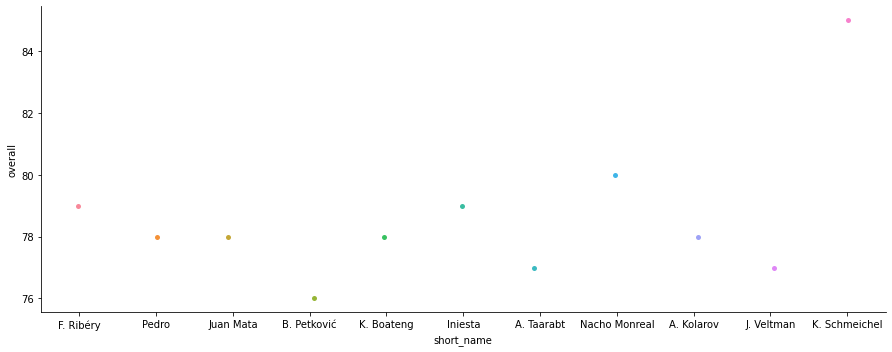

In [60]:
#View Team by Overall Score
sns.catplot(data=Team, x="short_name", y="overall",height=5, aspect=2.5, )